# Ablation

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('../src')
from ours_lightning_utils import load_our_model
from dataset_utils import get_dataset


In [2]:
# Load dataset
train_loader, test_loader, image_shape = get_dataset('5hdb', 1, 0, data_base_dir='../data/')


In [3]:
# Vanilla
vanilla_base_dir = '../output/ours_5hdb_20200701_173425'
vanilla_model = load_our_model(vanilla_base_dir, train_loader, test_loader, image_shape)
vanilla_model = vanilla_model.eval()

# DCGAN
dcgan_base_dir = '../output/ours_5hdb_20200701_173503'
dcgan_model = load_our_model(dcgan_base_dir, train_loader, test_loader, image_shape)
dcgan_model = dcgan_model.eval()

# DCGAN + Wasserstein
ours_base_dir = '../output/ours_5hdb_20200626_150655'
our_model = load_our_model(ours_base_dir, train_loader, test_loader, image_shape)
our_model = our_model.eval()


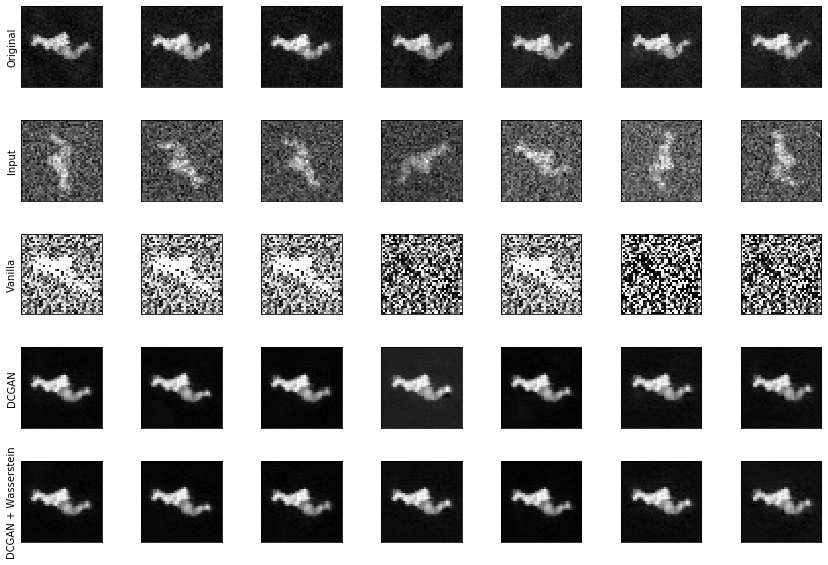

In [4]:
viz_num = 7

viz_idxs = np.linspace(0, len(test_loader.dataset) - 1, viz_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(5, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')

for i, idx in enumerate(viz_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    ax = axs[0, i]
    ax.imshow(imgs_rot0.squeeze(), cmap='gray')
    ax = axs[1, i]
    ax.imshow(imgs.squeeze(), cmap='gray')

    # Inference FC
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = vanilla_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[2, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

    # Inference DCGAN
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = dcgan_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[3, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

    # Inference DCGAN + Wasserstein
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[4, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Input')
axs[2, 0].set_ylabel('Vanilla')
axs[3, 0].set_ylabel('DCGAN')
axs[4, 0].set_ylabel('DCGAN + Wasserstein')

plt.tight_layout()
plt.show()


## Create video
Generate video of the training progress

In [5]:
def create_generated_progress_cmd(base_dir: str, out_path: str) -> str:
    print(base_dir, out_path)
    cmd = "ffmpeg -framerate 3 -pattern_type glob -i " + \
          "'{}/val_epoch_*_batch_015.jpg' ".format(base_dir) + \
          '-filter:v "crop=110:120:30:340"  -c:v libx264 -r 30 -pix_fmt yuv420p ' + out_path
    return cmd


In [6]:
output_dir = '../output/animations'
os.makedirs(output_dir, exist_ok=True)

# Vanilla
vanilla_out_path = os.path.join(output_dir, 'progress_vanilla.mp4')
cmd_vanilla = create_generated_progress_cmd(vanilla_base_dir, vanilla_out_path)
print(cmd_vanilla)
os.system(cmd_vanilla)

# DCGAN
dcgan_out_path = os.path.join(output_dir, 'progress_dcgan.mp4')
cmd_dcgan = create_generated_progress_cmd(dcgan_base_dir, dcgan_out_path)
print(cmd_dcgan)
os.system(cmd_dcgan)

# DCGAN + Wasserstein
ours_out_path = os.path.join(output_dir, 'progress_ours.mp4')
cmd_ours = create_generated_progress_cmd(ours_base_dir, ours_out_path)
print(cmd_ours)
os.system(cmd_ours)

# Merge
merged_output_path = os.path.join(output_dir, 'progress_merged.mp4')
cmd = "ffmpeg " + \
      f"-i {vanilla_out_path} -i {dcgan_out_path} -i {ours_out_path} " + \
      "-filter_complex \"[1:v][0:v]scale2ref=oh*mdar:ih[1v][0v];[2:v][0v]scale2ref=oh*mdar:ih[2v][0v];[0v][1v][2v]hstack=3,scale='2*trunc(iw/2)\':\'2*trunc(ih/2)'\" " + \
      merged_output_path
print(cmd)
os.system(cmd)


../output/ours_5hdb_20200701_173425 ../output/animations/progress_vanilla.mp4
ffmpeg -framerate 3 -pattern_type glob -i '../output/ours_5hdb_20200701_173425/val_epoch_*_batch_015.jpg' -filter:v "crop=110:120:30:340"  -c:v libx264 -r 30 -pix_fmt yuv420p ../output/animations/progress_vanilla.mp4
../output/ours_5hdb_20200701_173503 ../output/animations/progress_dcgan.mp4
ffmpeg -framerate 3 -pattern_type glob -i '../output/ours_5hdb_20200701_173503/val_epoch_*_batch_015.jpg' -filter:v "crop=110:120:30:340"  -c:v libx264 -r 30 -pix_fmt yuv420p ../output/animations/progress_dcgan.mp4
../output/ours_5hdb_20200626_150655 ../output/animations/progress_ours.mp4
ffmpeg -framerate 3 -pattern_type glob -i '../output/ours_5hdb_20200626_150655/val_epoch_*_batch_015.jpg' -filter:v "crop=110:120:30:340"  -c:v libx264 -r 30 -pix_fmt yuv420p ../output/animations/progress_ours.mp4
ffmpeg -i ../output/animations/progress_vanilla.mp4 -i ../output/animations/progress_dcgan.mp4 -i ../output/animations/progre

0